In [142]:
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle

from sklearn.metrics import confusion_matrix 
from sklearn.svm import SVC as svc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 



### 1.0 Dataset Overview

In [55]:
def unpickle(file_name):
    with open(file_name, 'rb') as f:
        img_set = pickle.load(f, encoding='bytes')
    if file_name == "batches.meta":
        return img_set
    data = []
    arr = []
    raw_data = img_set[b'data']
    for img_num in range(raw_data.shape[0]):
        data1 = raw_data[img_num, :].reshape(3, 1024).T # slice raw_data into 3 rows and transpose
        mean_int_val = list(np.mean(data1, axis=0))
        arr.append(mean_int_val)
        img = data1.reshape(32, 32, 3) # rearrange triplets of the transposed matrix into 32x32
        data.append(img) # make list of images
    try:
        labels = img_set[b'labels']
    except:
        labels = []
    return labels, data, arr

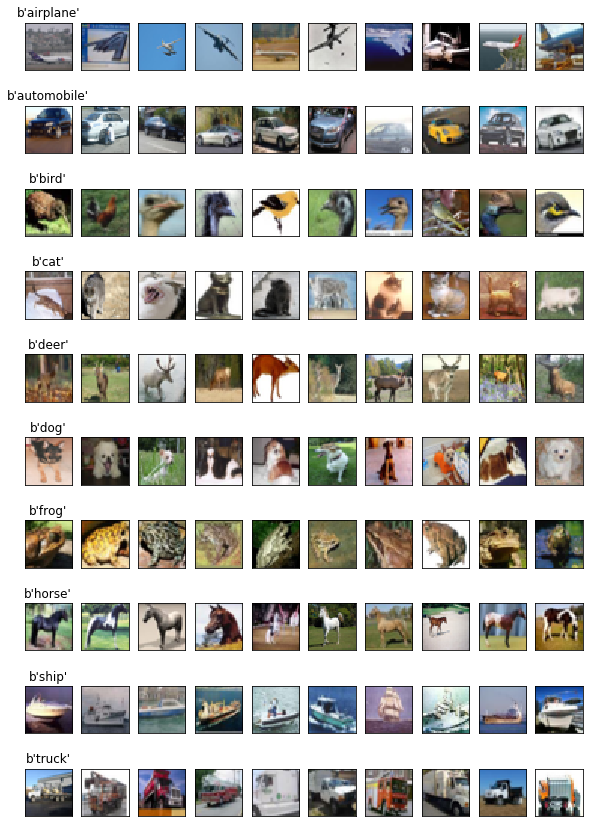

In [56]:
# Extract category names
lab_dict = unpickle("batches.meta")
lab = lab_dict[b'label_names']
lab_names = [s for s in lab]


# Extract Labels and Image Data
labels, data, void = unpickle("data_batch_4")
lab1 = [(label, data[idx]) for idx, label in enumerate(labels)]

# Sort the data on label number
lab1.sort(key=lambda x: x[0])

# Print First 10 images of each category
label_num = 0
plt.figure(figsize=(10, 15))
idx, idx2 = 1, 0
lab1_idx = 0
for label_num in range(10):
    label_count = 0
    lab1_idx += idx2
    for idx2, rec in enumerate(lab1[lab1_idx:]):
        lab2, img = rec
        if label_count < 10:
            plt.subplot(10, 10, idx)
            plt.imshow(img)
            if label_count == 0:
                plt.title(lab_names[label_num])
            plt.xticks([])
            plt.yticks([])
            idx += 1
            label_count += 1
        elif lab2 == label_num:
            continue
        else:
            break
plt.show()

In [123]:
def hog_feat(data):
    img = data[0]
    cell_size = (8, 8)
    block_size = (2, 2)
    nbins = 9
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
    
    h_ft = []
    for img in data:
        h = hog.compute(img)
        h_ft.append(list(h.reshape(1, -1)[0]))
    return h_ft


def feature_extraction(file_name, feat):
    labels, data, miv = unpickle(file_name)
    hft = hog_feat(data)

    if feat == "mean_intensity_value":
        features = miv.copy()
    else:
        features = hft.copy()
    return features, labels

In [136]:
def svc_CLF(train, labels, test, targets, krnl):   #krnl = "rbf" or "linear" or "poly"
    
    # Normalize Data
    train = np.array([np.array(t) for t in train])
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    
    test = np.array([np.array(t) for t in test])
    test = scaler.transform(test)
    
    # Apply Model
    np.random.seed() # reset seed for same numbers
    clf = svc(kernel=krnl, gamma='scale')
    clf.fit(train, labels)
    y1 = clf.predict(test)
    
    ans1 = np.array(targets)
    print("accuracy % ", (sum(y1==ans1)/len(y1))*100) 
    plt.figure()
    plt.imshow(confusion_matrix(targets, y1)), plt.title('Confusion Matrix')
    plt.show()

    return y1

### SVM Linear Mean Intensity

accuracy %  23.97


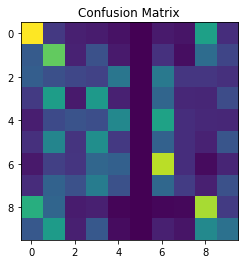

In [137]:
# Extract First Kind of the Features
train, labels = feature_extraction("data_batch_1", "mean_intensity_value")
test, targets = feature_extraction("test_batch", "mean_intensity_value")

# Fit Linear SVC model for Mean Intensity
svc1 = svc_CLF(train, labels, test, targets, 'linear') 

### SVM Linear HoG 

accuracy %  47.96


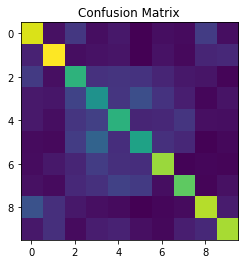

In [138]:
# Extract Second Kind of the Features
train, labels = feature_extraction("data_batch_1", "HoG")
test, targets = feature_extraction("test_batch", "HoG")

# Fit Linear SVC model for HoG
svc2 = svc_CLF(train, labels, test, targets, 'linear') 

HOG features give more than double accuracy compared to Mean Intensity Values. Mean Intensity just gives the average color of the image, but HoG is based on more features. Both features can give similar accuracies when the image classes just show different colors.

### 2.2 SVM Non-Linear Polynomial

accuracy 0.5681


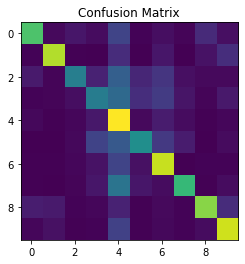

In [118]:
# Fit Polynomial kernel for HOG Features
train, labels = feature_extraction("data_batch_1", "2")
test, targets = feature_extraction("test_batch", "2")
svc3 = svc_CLF(train, labels, test, targets, 'poly')

### 2.2 SVM Non-Linear Rbf

accuracy 0.6175


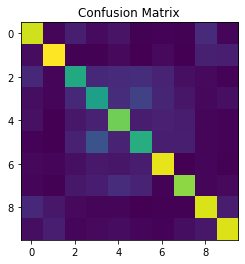

In [119]:
# Fit Radial Basis Function kernel for HOG Features
train, labels = feature_extraction("data_batch_1", "2")
test, targets = feature_extraction("test_batch", "2")
svc4 = svc_CLF(train, labels, test, targets, 'rbf')

RBF gives better accuracy than Polynomial
Polynomial spans the whole image while RBF focuses on a localized region, so  rbf is better.

In [143]:
def rf_CLF(train, labels, test, targets, ntrees):
    clf = RandomForestClassifier(n_estimators=ntrees, criterion='entropy')
    clf.fit(train, labels)
    y1 = clf.predict(test)
    ans1 = np.array(targets)
    print("accuracy % ", (sum(y1==ans1)/len(y1))*100) 
    plt.figure()
    plt.imshow(confusion_matrix(targets, y1)), plt.title('Confusion Matrix')
    plt.show()
    return y1

### 3.1 RF - Exploring Performance of HoG Features

accuracy %  51.739999999999995


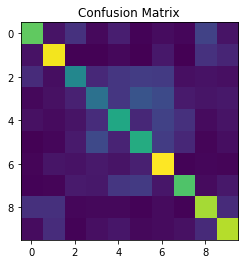

In [144]:
rf1 = rf_CLF(train, labels, test, targets, 100)

rf accuracy is nearly 10% less than rbf accuarcy

### 3.2 RF - Exploring Dierent Number of Trees (estimators)

accuracy %  48.07


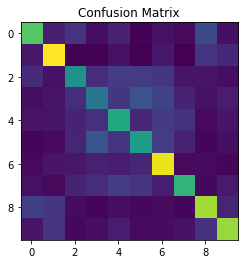

In [145]:
# trees 40, 200, 250
rf2 = rf_CLF(train, labels, test, targets, 40)

accuracy %  53.669999999999995


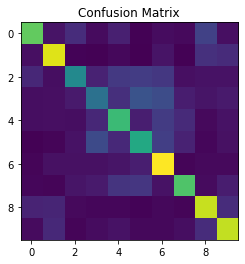

In [147]:
rf3 = rf_CLF(train, labels, test, targets, 200)


accuracy %  54.15


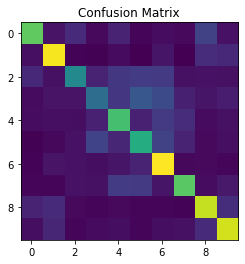

In [148]:
rf3 = rf_CLF(train, labels, test, targets, 250)

The accuracy increases with the increased number of trees. 250 trees give the best accuracy.

### 4.1 Performance Analysis

SVM with RBF is the best performing with an accuracy of 61.75%. RF with 250 trees is the best performing with an accuracy of 54.15%. For SVM linear mean intensity and linear HoG, the accuracies are 23.97% and 47.96%. SVM non linear Polynomial has an accuracy of 56.81%. For RF, with different ranges of trees, the accuracy stays around 50%, but with SVM non-linear we get better accuracies. Thus, it can be seen that SVM is better in all cases. There is no class where RF is performing better.`

### 4.2 Exploring Different Parameters of HoG

In [151]:
def hog_feat2(dat, cs, bs, nb):
    img = data[0]
    cell_size = (cs, cs)
    block_size = (bs, bs)
    nbins = nb
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
    h_ft = []
    for img in dat:
        h = hog.compute(img)
        h_ft.append(list(h.reshape(1, -1)[0]))
    return h_ft

def feature_extraction2(file_name, cs, bs, nb):
    labels, data, miv = unpickle(file_name)
    hft = hog_feat2(data, cs, bs, nb)
    features = hft.copy()
    return features, labels

accuracy %  59.37


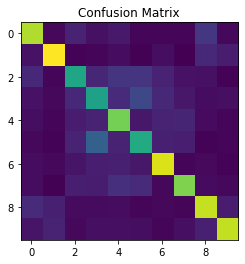

In [152]:
# HoG Variation 2 -- takes around 10 minutes 
train, labels = feature_extraction2("data_batch_1", 4, 2, 9)
test, targets = feature_extraction2("test_batch", 4, 2, 9)
svc5 = svc_CLF(train, labels, test, targets, 'rbf')

accuracy %  61.92999999999999


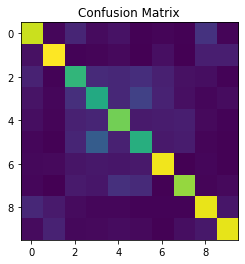

In [153]:
# HoG variation 3 -- takes around 10 minutes
train, labels = feature_extraction2("data_batch_1", 4, 4, 9)
test, targets = feature_extraction2("test_batch", 4, 4, 9)
svc5 = svc_CLF(train, labels, test, targets, 'rbf')

accuracy %  61.62


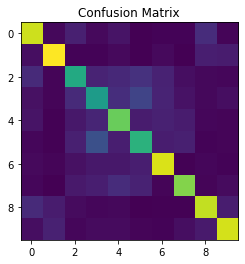

In [154]:
# HoG variation 4 -- takes around 5 minutes
train, labels = feature_extraction2("data_batch_1", 8, 2, 13)
test, targets = feature_extraction2("test_batch", 8, 2, 13)
svc5 = svc_CLF(train, labels, test, targets, 'rbf')

Square Cell Size used 8, 4, 4, 8
Square Block Size used 2, 2, 4, 2
nbins 9, 9, 9, 13
Accuracies are 61.76, 59.37, 61.93, 61.62.  They have almost the same accuracies.

### 4.3 Folded Validation

In [155]:
test, targets = feature_extraction("test_batch", "2")
train1, labels1 = feature_extraction("data_batch_1", "2")
train2, labels2 = feature_extraction("data_batch_2", "2")
train3, labels3 = feature_extraction("data_batch_4", "2")
train_3 = train1 + train2; labels_3 = labels1 + labels2
train_2 = train1 + train3; labels_2 = labels1 + labels3
train_1 = train2 + train3; labels_1 = labels2 + labels3

accuracy %  64.4


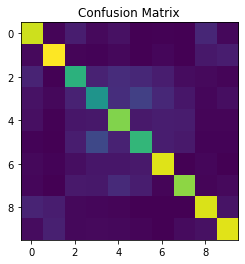

accuracy %  64.61


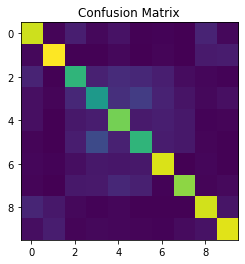

accuracy %  64.22


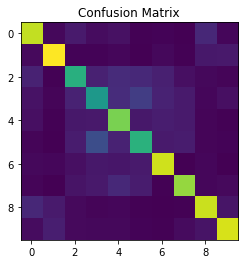

In [156]:
svc6 = svc_CLF(train_1, labels_1, test, targets, "rbf")
svc7 = svc_CLF(train_2, labels_2, test, targets, "rbf")
svc8 = svc_CLF(train_3, labels_3, test, targets, "rbf")